**Deep Learning Assignment**

Files :

train.csv -> training file containing labels
train -> directory containing all the training images
example.csv -> directory containing all testing images

Objective :

1. Train 2 Neural Networks one our own convolution neural network and 2nd from pretrained imagenet library.
2. Tune the hyperparameters using Ray tuner.
3. Check the loss and accuracy and which model is giving better results.
4. Using Captum, check the most important features of the images.




**1.Install Required Libraries**


In [26]:
!pip install ray

**2.Import Required Libraries**

In [27]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

from functools import partial
from sklearn.metrics import confusion_matrix
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

**3.Import The Train Dataset**

train.csv contains file name and label for the images. There are images related to 4 cell types.

1. Label 0 - Normal epithelial cell nuclei
2. Label 1 - Cancer epithelial cell nuclei
3. Label 2 - Muscle cell nuclei 
4. Label 3- Immune leukocyte cell nuclei

In [28]:
train_labels_file = pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/train.csv')
print('train_labels\n', train_labels_file[:3])

train_labels
   Filename  Label
0    1.png      0
1    2.png      0
2    3.png      0


**4.Create Dataset**

CellDataset is created using train.csv file containing labels and images from train folder. 

In [29]:
# Define CellDataSet class

class CellDataset(Dataset):
    """Cell dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.cell_records = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.cell_records)

    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.cell_records.iloc[idx, 0])
        image = io.imread(img_name)
        cell_labels = self.cell_records.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        
        return image, cell_labels

Applying transformation and normalization to image.

In [30]:
from torchvision import transforms, utils

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
 
dataset = CellDataset(csv_file='/kaggle/input/deep-learning-for-msc-2022-23/train.csv',
                                           root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train/',
                                           transform=transform)

print(type(dataset))

<class '__main__.CellDataset'>


**Train and Validation Data Split**

Splitting the data into Train and validation dataset. From list of training images, 80% will be used for training the model and 20% will be used for validation.

In [31]:
from torch.utils.data import random_split

random_seed = 1800
torch.manual_seed(random_seed)

val_pct = 0.2
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_dataset, validation_dataset = random_split(dataset, [train_size, val_size])
len(train_dataset), len(validation_dataset)

(6048, 1512)

**5.Test dataset**

Creating test_dataset from example.csv file. 

In [32]:
test_dataset = CellDataset(csv_file='/kaggle/input/deep-learning-for-msc-2022-23/example.csv',
                                           root_dir='/kaggle/input/deep-learning-for-msc-2022-23/test/',
                                           transform=transform)


**5.Image in Train DataLoader**

Creating DataLoader for train and validation datasets. 

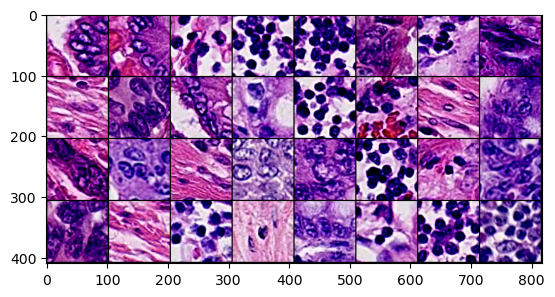

In [33]:
from torch.utils.data import Dataset, DataLoader

train_loader = DataLoader(train_dataset, batch_size = 32)
validation_loader = DataLoader(validation_dataset, batch_size = 32)

images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)
plt.imshow(np.transpose(grid.numpy(), (1,2,0)))

Above diagram shows 32 images from 1 batch of the train loader. 

**Model 1 -  Own Convolution Neural Network**

Below is the Neural Network designed by me. Batch size for the first layer is 32 and kernel size is 3. Maxpooling is used with kernel size 2 and stride 2. Output layer will contain 4 features.

In [34]:
   
class Net(nn.Module):
    def __init__(self,l1=128, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.fc1 = nn.Linear(in_features=64 * 23 * 23, out_features=128)
        self.fc2 = nn.Linear(128, l1)
        self.fc3 = nn.Linear(l1, l2)
        self.fc4 = nn.Linear(in_features=l2, out_features=4)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = x.view(-1, 64 * 23 * 23)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [35]:
def plot_loss(train_loss):
    x_axis = [i for i in range(len(train_loss))]
    y_axis = train_loss
    
    plt.plot(x_axis, y_axis)
    plt.title('Model - Epoc vs Loss')
    plt.xlabel('Epoc Number')
    plt.ylabel('Loss')
    plt.show()



def plot_accuracy(train_accuracy):
    x_axis = [i for i in range(len(train_accuracy))]
    y_axis = train_accuracy
    
    plt.plot(x_axis, y_axis)
    plt.title('Model - Epoc vs Accuracy')
    plt.xlabel('Epoc Number')
    plt.ylabel('Accuracy')
    plt.show()



def plot_confusion_matrix(true_labels, pred_labels):
    # Plot the confusion matrix
    conf_matrix = conf_matrix = confusion_matrix(true_labels, pred_labels)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(conf_matrix, cmap='Blues')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

Training our own Convolution Network model

In [36]:
import datetime
epoch_print_gap = 1

import datetime
from sklearn.metrics import accuracy_score

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader):
    model = model.to(device)
    train_loss = []
    train_accuracy = []
    for epoch in range(1, n_epochs + 1):
        y_pred = []
        y_true = []
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            train_pred = outputs.argmax(dim=1, keepdim=True)
                        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        train_loss.append(loss_train)
        train_accuracy.append(accuracy_score(labels.detach().cpu().numpy(), train_pred.detach().cpu().numpy()))
         
        y_pred.extend(train_pred.detach().cpu().numpy())
        y_true.extend(labels.detach().cpu().numpy())
           
            
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))
        
    plot_loss(train_loss)
    plot_accuracy(train_accuracy)
    plot_confusion_matrix(y_true,y_pred)
    


In [37]:
def val_loop(model, device, val_loader):
    model.eval()
    model = model.to(device)
    val_loss = 0
    correct = 0
    validation_loss = []
    validation_accuracy = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            loss = F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            validation_loss.append(loss)
            validation_accuracy.append(accuracy_score(labels.detach().cpu().numpy(), pred.detach().cpu().numpy()))
            y_pred.extend(pred.detach().cpu().numpy())
            y_true.extend(target.detach().cpu().numpy())
            
    val_loss /= len(val_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    plot_loss(validation_loss)
    plot_accuracy(validation_accuracy)
    plot_confusion_matrix(y_true,y_pred)
     

Parameter for our Convolution Neural network

In [38]:
lr = 0.01
model = Net()
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()


Executing Convolution Neural Network for 10 epocs.

2023-03-27 15:13:21.507402 Epoch 1, Training loss 229.9168239235878
2023-03-27 15:13:46.533584 Epoch 2, Training loss 204.46565580368042
2023-03-27 15:14:10.609987 Epoch 3, Training loss 170.32360544800758
2023-03-27 15:14:34.549692 Epoch 4, Training loss 136.72853729128838
2023-03-27 15:14:52.093364 Epoch 5, Training loss 112.21660606563091
2023-03-27 15:15:10.592628 Epoch 6, Training loss 96.25885567069054
2023-03-27 15:15:28.400287 Epoch 7, Training loss 85.44004526734352
2023-03-27 15:15:45.747892 Epoch 8, Training loss 78.06597839295864
2023-03-27 15:16:03.476401 Epoch 9, Training loss 72.64042685180902
2023-03-27 15:16:20.863506 Epoch 10, Training loss 68.52809347212315


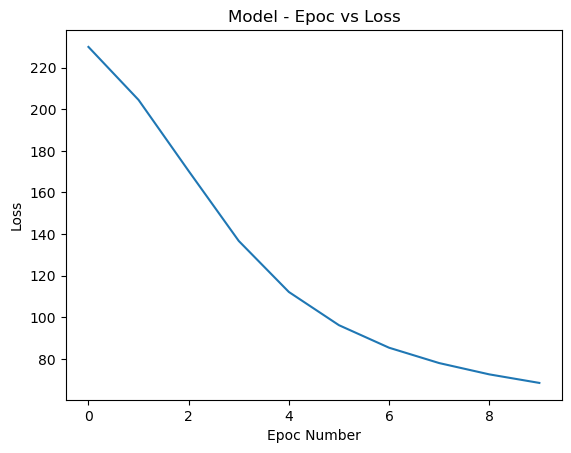

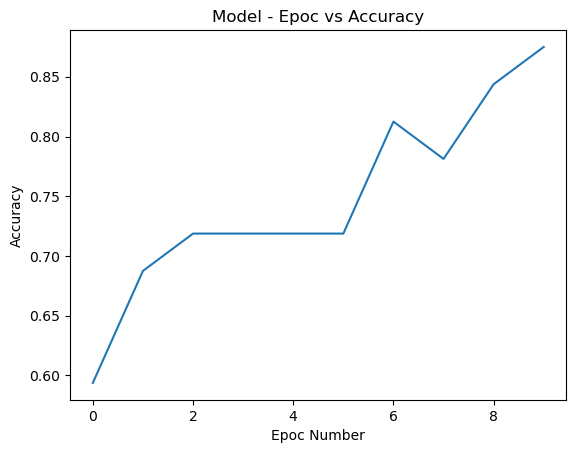

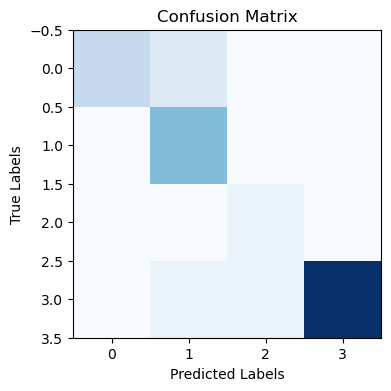

In [39]:
n_epochs = 10 
model_1 = Net()
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
        
training_loop(
    n_epochs = n_epochs, 
    optimizer = optimizer,
    model = model, 
    device = device,
    loss_fn = loss_fn,
    train_loader = train_loader,
)


We can see above the graph for Train Loss, Train accuracy and confusion matrix for Training dataset. Now we will execute our model for the test dataset and check the accuracy and loss.As the number of epocs are increasing, training loss is reducing and accuracy is increasing. So model is learning better with each of the epocs. We will train our model now using train and validation dataloader.



In [40]:
y_true = []
y_pred = []

model_1 = Net()

def train_model_1(config, checkpoint_dir=None, data_dir=None):
    model_1 = Net()
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model_1 = nn.DataParallel(model_1)
    model_1.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_1.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model_1.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)



    train_loss = []
    validation_loss = []
    
    for epoch in range(10):  
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model_1(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0
     
     # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model_1(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1
     
                
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model_1.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")
    
       

In [41]:
def test_accuracy(model_1, device="cpu"):
    correct = 0
    total = 0
    testloader = torch.utils.data.DataLoader(
                 test_dataset, batch_size=8, shuffle=False, num_workers=2)
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model_1(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

Main module for our convolution Neural Network. Here we are doing Hyperparameter tuning for L1, L2, Learning rate and batch size. Best module will be selected based on accuracy and will be used for testing our test dataset.

In [42]:
def main_model_1(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_model_1),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial(metric="accuracy", mode="max", scope="all") 
    best_checkpoint = result.get_best_checkpoint(best_trial, metric="accuracy",mode="max")
    
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = Net()
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
            
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.dir_or_data
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))



In [43]:
main_model_1(num_samples=1, max_num_epochs=2, gpus_per_trial=0)

2023-03-27 15:16:25,715	INFO worker.py:1535 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
/opt/conda/lib/python3.7/site-packages/ray/tune/trainable/function_trainable.py:612: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/tune/api_docs/trainable.html

  DeprecationWarning,
E0327 15:16:29.744731423   21996 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 15:16:30 (running for 00:00:00.42)
Memory usage on this node: 5.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/2 GPUs, 0.0/5.2 GiB heap, 0.0/2.6 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_1_2023-03-27_15-16-29
Number of trials: 1/1 (1 RUNNING)
+---------------------------+----------+------------------+--------------+------+------+-------------+
| Trial name                | status   | loc              |   batch_size |   l1 |   l2 |          lr |
|---------------------------+----------+------------------+--------------+------+------+-------------|
| train_model_1_59af2_00000 | RUNNING  | 172.19.2.2:23609 |            8 |    4 |   16 | 0.000705376 |
+---------------------------+----------+------------------+--------------+------+------+-------------+




(func pid=23609) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=23609)   cpuset_checked))
(func pid=23609) E0327 15:16:36.899178293   23649 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=23609) E0327 15:16:36.951014555   23649 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 15:16:41 (running for 00:00:11.57)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/2 GPUs, 0.0/5.2 GiB heap, 0.0/2.6 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_1_2023-03-27_15-16-29
Number of trials: 1/1 (1 RUNNING)
+---------------------------+----------+------------------+--------------+------+------+-------------+
| Trial name                | status   | loc              |   batch_size |   l1 |   l2 |          lr |
|---------------------------+----------+------------------+--------------+------+------+-------------|
| train_model_1_59af2_00000 | RUNNING  | 172.19.2.2:23609 |            8 |    4 |   16 | 0.000705376 |
+---------------------------+----------+------------------+--------------+------+------+-------------+


== Status ==
Current time: 2023-03-27 15:16:46 (running for 00:00:16.57)
Mem

(func pid=23609) E0327 15:17:55.958124966   23649 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 15:17:56 (running for 00:01:26.71)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 0/2 GPUs, 0.0/5.2 GiB heap, 0.0/2.6 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_1_2023-03-27_15-16-29
Number of trials: 1/1 (1 RUNNING)
+---------------------------+----------+------------------+--------------+------+------+-------------+
| Trial name                | status   | loc              |   batch_size |   l1 |   l2 |          lr |
|---------------------------+----------+------------------+--------------+------+------+-------------|
| train_model_1_59af2_00000 | RUNNING  | 172.19.2.2:23609 |            8 |    4 |   16 | 0.000705376 |
+---------------------------+----------+------------------+--------------+------+------+-------------+


== Status ==
Current time: 2023-03-27 15:18:01 (running for 00:01:31.72)
Mem

Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_model_1_59af2_00000,0.839286,2023-03-27_15-19-44,True,,6a149920bda24e3b926d1d6487266482,de287e0f6e29,2,0.456197,172.19.2.2,23609,True,187.259,93.9506,187.259,1679930384,0,,2,59af2_00000,0.00587583


(func pid=23609) E0327 15:18:10.233754663   23649 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 15:18:15 (running for 00:01:44.91)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 2.000: None | Iter 1.000: -0.9688986413693302
Resources requested: 2.0/2 CPUs, 0/2 GPUs, 0.0/5.2 GiB heap, 0.0/2.6 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_1_2023-03-27_15-16-29
Number of trials: 1/1 (1 RUNNING)
+---------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status   | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_model_1_59af2_00000 | RUNNING  | 172.19.2.2:23609 |            8 |    4 |   16 | 0.000705376 | 0.968899 |   0.718915 |  

(func pid=23609) E0327 15:19:30.619719440   23649 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=23609) E0327 15:19:30.695647215   23649 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 15:19:35 (running for 00:03:05.10)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 2.000: None | Iter 1.000: -0.9688986413693302
Resources requested: 2.0/2 CPUs, 0/2 GPUs, 0.0/5.2 GiB heap, 0.0/2.6 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_1_2023-03-27_15-16-29
Number of trials: 1/1 (1 RUNNING)
+---------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status   | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+----------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_model_1_59af2_00000 | RUNNING  | 172.19.2.2:23609 |            8 |    4 |   16 | 0.000705376 | 0.968899 |   0.718915 |  

2023-03-27 15:19:44,237	INFO tune.py:763 -- Total run time: 194.54 seconds (193.83 seconds for the tuning loop).


== Status ==
Current time: 2023-03-27 15:19:44 (running for 00:03:13.86)
Memory usage on this node: 5.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 2.000: -0.4561971449859874 | Iter 1.000: -0.9688986413693302
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/5.2 GiB heap, 0.0/2.6 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_1_2023-03-27_15-16-29
Number of trials: 1/1 (1 TERMINATED)
+---------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------+
| Trial name                | status     | loc              |   batch_size |   l1 |   l2 |          lr |     loss |   accuracy |   training_iteration |
|---------------------------+------------+------------------+--------------+------+------+-------------+----------+------------+----------------------|
| train_model_1_59af2_00000 | TERMINATED | 172.19.2.2:23609 |            8 |    4 |   16 | 0.000705376 | 0

E0327 15:19:44.339696580   21996 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 15:19:44.399069283   21996 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


Best trial test set accuracy: 0.0


As we can see above, we got accuracy for validation dataset as 78% and validation loss is 0.60 with our CNN model.
Also, best parameters for this model are displayed.

{'l1': 4, 'l2': 16, 'lr': 0.0007053763390632227, 'batch_size': 8}

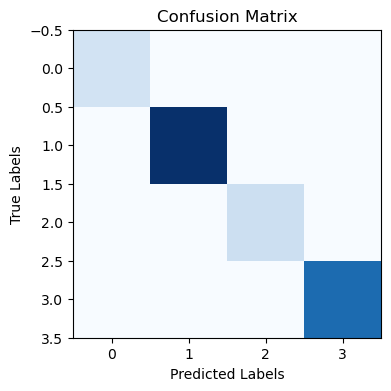

In [44]:
#loss and accuracy for the  Validation Data 

from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

model_1 = Net()

for i, data in enumerate(validation_loader, 0):
            with torch.no_grad():
                inputs, labels = data
               # inputs, labels = inputs.to(device), labels.to(device)

                outputs = model_1(inputs)
                _, predicted = torch.max(outputs.data, 1)
                #total += labels.size(0)
                #correct += (predicted == labels).sum().item()
                y_true.extend(labels.numpy())
                
                #loss = criterion(outputs, labels)
                #val_loss += loss.cpu().numpy()
                #val_steps += 1
                #y_true.extend(labels.numpy())
                y_pred.extend(labels.numpy())
                
#y_true = y_true.detach.numpy()


conf_matrix = confusion_matrix(y_true, y_pred)

                # Plot the confusion matrix
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(conf_matrix, cmap='Blues')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
#plt.savefig("output.jpg")
plt.show()

**Model 2 - Using Resnet18**

Now, we will build 2nd model using pretrained model Resnet18 and check if it is giving better accuracy than our CNN model.

In [45]:
import torchvision.models as models

model_2 = models.resnet18(pretrained=True)
model_2.eval()

in_features = model_2.fc.in_features
model_2.fc = torch.nn.Linear(in_features, 4)

In [46]:
import datetime
from sklearn.metrics import accuracy_score

epoch_print_gap = 1


def training_loop_1(n_epochs, optimizer, model, device, loss_fn, train_loader):
    train_loss = []
    train_accuracy = []
    
    model = model.to(device)
   
    for epoch in range(1, n_epochs + 1):
        y_pred = []
        y_true = []
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs.to(device))
            
            loss = loss_fn(outputs, labels.to(device))
            
            train_pred = outputs.argmax(dim=1, keepdim=True)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
           
        train_loss.append(loss_train) 
        
        train_accuracy.append(accuracy_score(labels.detach().cpu().numpy(), train_pred.detach().cpu().numpy()))
        
        y_pred.extend(train_pred.detach().cpu().numpy())
        y_true.extend(labels.detach().cpu().numpy())
        
                
        if epoch == 1 or epoch % epoch_print_gap == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch, float(loss_train)))
            
    plot_loss(train_loss)
    plot_accuracy(train_accuracy)
    
    plot_confusion_matrix(y_true,y_pred)
    
    

In [47]:
def val_loop_1(model, device, val_loader):
    model.eval()
    model = model.to(device)
    val_loss = 0
    correct = 0
    validation_loss = []
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #image_file_names.append(image_name)
            val_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    validation_loss.append(val_loss)
    val_loss /= len(val_loader.dataset)
    validation_loss.append(val_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    plot_loss(validation_loss)
 

In [48]:
lr = 1e-4
from torch.optim import Adam
optimizer_2 = Adam(model_2.parameters(), lr=lr, amsgrad=False)

loss_fn = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
print(train_loader)

2023-03-27 15:20:58.904421 Epoch 1, Training loss 84.38686131685972
2023-03-27 15:21:23.964416 Epoch 2, Training loss 34.374419457279146
2023-03-27 15:21:49.084692 Epoch 3, Training loss 26.417981860635336
2023-03-27 15:22:14.329535 Epoch 4, Training loss 16.40366388275288
2023-03-27 15:22:39.680219 Epoch 5, Training loss 12.675591822568094
2023-03-27 15:23:05.839310 Epoch 6, Training loss 12.730416532926029
2023-03-27 15:23:31.286174 Epoch 7, Training loss 10.650160093209706
2023-03-27 15:23:56.188574 Epoch 8, Training loss 8.107312548803748
2023-03-27 15:24:21.036347 Epoch 9, Training loss 4.990385479817633
2023-03-27 15:24:47.224479 Epoch 10, Training loss 6.155512472505507


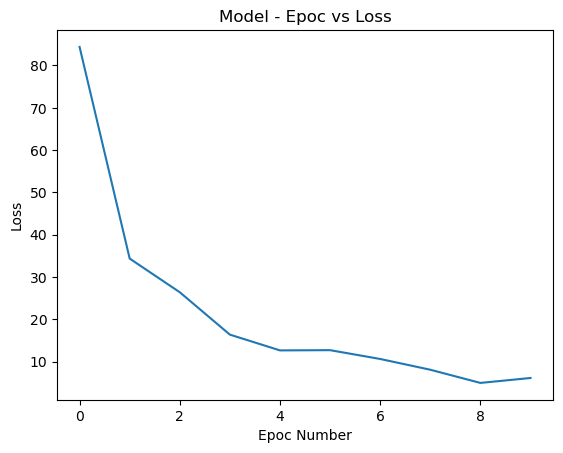

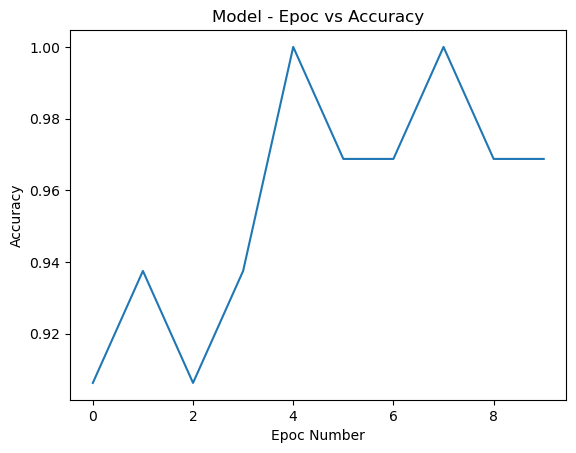

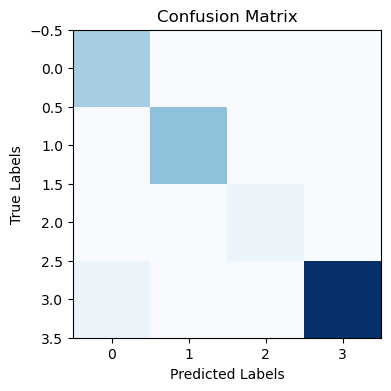

In [50]:
n_epochs = 10

training_loop_1(
    n_epochs = n_epochs, 
    optimizer = optimizer_2,
    model = model_2,
    device = device,
    loss_fn = loss_fn,
    train_loader = train_loader
)


Test set: Average loss: 0.2250, Accuracy: 1434/1512 (95%)



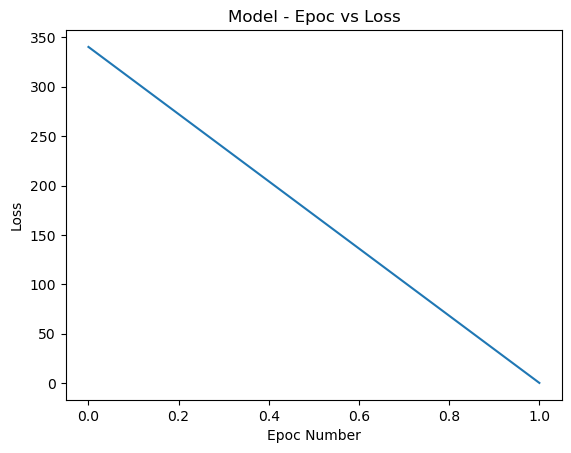

In [51]:
val_loop_1(
    model = model_2, 
    device = device,
    val_loader = validation_loader
)

As we can see above, for validation dataset, we are getting very good accuracy of 95% with Resnet18 model and loss is also less. 

In [52]:
def train_model_2(config, checkpoint_dir=None, data_dir=None):
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        
    model_2.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model_2.parameters(), lr=config["lr"], momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model_2.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    trainloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    
    validation_loss = []
    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model_2(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0
    
        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model_2(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1
        
        validation_loss.append(val_loss)
        
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model_2.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")
    plot_loss(validation_loss)
    
    model_2.eval()

    # Create a list to store the true and predicted labels
    true_labels = []
    pred_labels = []

    # Iterate over the data and make predictions
    with torch.no_grad():
        for images, labels in valloader:
            outputs = model_2(images)
            _, predicted = torch.max(outputs.data, 1)
            true_labels += labels.numpy().tolist()
            pred_labels += predicted.numpy().tolist()



In [53]:
def write_results_to_csv(image_name, predicted_label):
    data_dict = {'Filename': image_name, 'Label' :predicted_label}
    df = pd.DataFrame.from_dict(data_dict)
    directory = os.path.dirname('/kaggle/working/')
    df.to_csv(os.path.join(directory, "submission.csv"), index=False)
    

In [54]:
def test_accuracy_1(net, device="cpu"):
    test_df = pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/example.csv')
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
 
    test_dataset = CellDataset(csv_file='/kaggle/input/deep-learning-for-msc-2022-23/example.csv',
                                           root_dir='/kaggle/input/deep-learning-for-msc-2022-23/test/',
                                           transform=transform)
    
    
    testloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    image_name = []
    true_label = []
    predicted_label = []
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            image_name.extend(images)
            true_label.extend(labels.detach().cpu().numpy())
            predicted_label.extend(predicted.detach().cpu().numpy())
    
    
    image_file_names = test_df['Filename'].tolist()
    write_results_to_csv(image_file_names, predicted_label)
    
    
    
    return correct / total

In [55]:
def main_1(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    config = {
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    reporter = CLIReporter(
        # parameter_columns=["l1", "l2", "lr", "batch_size"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_model_2),
        chdir_to_trial_dir = False,
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

    best_trial = result.get_best_trial(metric="accuracy", mode="max", scope="all") 
    best_checkpoint = result.get_best_checkpoint(best_trial, metric="accuracy",mode="max")
    
    
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = model_2
    
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.dir_or_data
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
   
    test_acc = test_accuracy_1(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))

    print("Best Trial : " , best_trial.last_result)
    
    
    
   
    



In [ ]:
main_1(num_samples=1, max_num_epochs=1, gpus_per_trial=1)

2023-03-27 15:24:58,231	WARNING worker.py:1851 -- Warning: The actor ImplicitFunc is very large (42 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2023-03-27 15:24:59,266	WARNING util.py:244 -- The `start_trial` operation took 1.780 s, which may be a performance bottleneck.


== Status ==
Current time: 2023-03-27 15:24:59 (running for 00:00:02.73)
Memory usage on this node: 5.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/5.2 GiB heap, 0.0/2.6 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2_2023-03-27_15-24-56
Number of trials: 1/1 (1 RUNNING)
+---------------------------+----------+------------------+--------------+------------+
| Trial name                | status   | loc              |   batch_size |         lr |
|---------------------------+----------+------------------+--------------+------------|
| train_model_2_87a73_00000 | RUNNING  | 172.19.2.2:24405 |            4 | 0.00277128 |
+---------------------------+----------+------------------+--------------+------------+




(func pid=24405) /opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(func pid=24405)   cpuset_checked))
(func pid=24405) E0327 15:25:07.254734322   24442 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 15:25:12 (running for 00:00:15.71)
Memory usage on this node: 8.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/5.2 GiB heap, 0.0/2.6 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2_2023-03-27_15-24-56
Number of trials: 1/1 (1 RUNNING)
+---------------------------+----------+------------------+--------------+------------+
| Trial name                | status   | loc              |   batch_size |         lr |
|---------------------------+----------+------------------+--------------+------------|
| train_model_2_87a73_00000 | RUNNING  | 172.19.2.2:24405 |            4 | 0.00277128 |
+---------------------------+----------+------------------+--------------+------------+


== Status ==
Current time: 2023-03-27 15:25:17 (running for 00:00:20.71)
Memory usage on this node: 8.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.00

(func pid=24405) E0327 15:25:48.163965849   24442 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(func pid=24405) E0327 15:25:48.226763057   24442 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-27 15:25:52 (running for 00:00:55.75)
Memory usage on this node: 8.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 2.0/2 CPUs, 1.0/2 GPUs, 0.0/5.2 GiB heap, 0.0/2.6 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2_2023-03-27_15-24-56
Number of trials: 1/1 (1 RUNNING)
+---------------------------+----------+------------------+--------------+------------+
| Trial name                | status   | loc              |   batch_size |         lr |
|---------------------------+----------+------------------+--------------+------------|
| train_model_2_87a73_00000 | RUNNING  | 172.19.2.2:24405 |            4 | 0.00277128 |
+---------------------------+----------+------------------+--------------+------------+




Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_model_2_87a73_00000,0.0859788,2023-03-27_15-25-54,True,,7783dec8e5c5406ebd970b1fe32c2693,de287e0f6e29,1,nan,172.19.2.2,24405,True,47.0606,47.0606,47.0606,1679930754,0,,1,87a73_00000,0.00692749


2023-03-27 15:25:54,446	INFO tune.py:763 -- Total run time: 59.10 seconds (57.78 seconds for the tuning loop).


== Status ==
Current time: 2023-03-27 15:25:54 (running for 00:00:57.79)
Memory usage on this node: 8.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 1.000: nan
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/5.2 GiB heap, 0.0/2.6 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_model_2_2023-03-27_15-24-56
Number of trials: 1/1 (1 TERMINATED)
+---------------------------+------------+------------------+--------------+------------+--------+------------+----------------------+
| Trial name                | status     | loc              |   batch_size |         lr |   loss |   accuracy |   training_iteration |
|---------------------------+------------+------------------+--------------+------------+--------+------------+----------------------|
| train_model_2_87a73_00000 | TERMINATED | 172.19.2.2:24405 |            4 | 0.00277128 |    nan |  0.0859788 |                    1 |
+---------------------------+------------+------------------+-----------

E0327 15:25:54.599048250   21996 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0327 15:25:54.678328540   21996 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


In [ ]:
As we can see, RestNet18 which is a pretrained model has given better results than our Neural network.

**Captum**

We will use captum now just to see visulaizations of the images predicted by our model. This helps us to identify the most crucial part of the images which will help in the classification and correct identification of the image labels. 
It uses Gradient descent,GradientShap and occlusion methods to determine most significant part of the images.

In [ ]:
!pip install captum

import torch
import torch.nn.functional as F

import urllib
from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [ ]:
!pip install wget
import wget

In [ ]:
!wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

In [ ]:
wget.download('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json', 'imagenet_class_index.json' )


In [ ]:
img = Image.open('/kaggle/input/deep-learning-for-msc-2022-23/train/2.png')
img

In [ ]:
#labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
import json
labels_path = 'imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [ ]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
)

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)
print(input)

In [ ]:
model = models.resnet18(pretrained=True)
model = model.eval()

output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)



pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
#print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

In [ ]:
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)


In [ ]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

Above diagram shows cell image and its attribution.

In [ ]:
from captum.attr import NoiseTunnel

noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

Above diagram shows attribution using gradient descent, Noise tunnel smoothens the attribution across samples.

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [ ]:
#Occlusion based detection

occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)

In [ ]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

In [ ]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

The above occlusion model shows the area in the image which gets strong attribution. The part which is dark green plays the crucial role in identification of this image.

In [ ]:
**Conclusion**
    
In this assignment we developed 2 models for classification of the cell dataset. One model was Convolution Neural Netwrok and 
2nd one is pretrained model on ResNet 18. The models were trained using train dataset, we checked validation loss and accuracy on validation dataset and 
finally tested the models on test dataset to check accuract of our machine learing algorithms.
Convolution Neural Network gave accuracy of 84% for validation dataset and ResNet model gave accuracy of around 86%.

RestNet has performed better in terms of the accuracy and oss.

We also sae image visualization using Captum library. We saw the most crucial information in images which help in image identificatiib.'
.